In this notebook:
    - station data and normalized temperature evolution data are merged
    - different normalizations comparison (plot and regression)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import time as t
import re
from sklearn import datasets, linear_model
import seaborn as sns
%matplotlib inline
import matplotlib.patches as mpatches

In [2]:
#import stations with isUrban flag for selected cols
cols = ['Station ID','Station Name', 'Latitude','Longitude','Elevation (m)', 'isUrban' ]
df_stations = pd.read_csv('Dades/OUTPUT XX Filtered Stations Urban-No Urban.csv', skipinitialspace = True, usecols = cols)

#import normalized data
df = pd.read_csv('Dades/OUTPUT 04 Dades Normalitzades.csv')

In [3]:
#merge data with urban information
df_urban = pd.merge(df,df_stations,how='inner',  on ='Station ID')
df_urban.head()

,Date,Month,Station ID,Temperature (C),Temperature Norm,Temperature Norm Smoothed (ewma),Temperature Norm Smoothed (moving avg),Year,DateISO,Station Name,Latitude,Longitude,Elevation (m),isUrban
0,1951.042,1,275,10.2,0.39,0.390000,-0.91,1951,1951-01-01,PALMA MALLORCA/SON BONET,39.6,2.7,45,1
1,1952.042,1,275,8.8,-1.01,-0.485000,-0.96,1952,1952-01-01,PALMA MALLORCA/SON BONET,39.6,2.7,45,1
2,1953.042,1,275,7.7,-2.11,-1.314082,-0.17,1953,1953-01-01,PALMA MALLORCA/SON BONET,39.6,2.7,45,1
3,1954.042,1,275,8.7,-1.11,-1.220294,-0.17,1954,1954-01-01,PALMA MALLORCA/SON BONET,39.6,2.7,45,1
4,1955.042,1,275,12.8,2.99,0.605822,-0.39,1955,1955-01-01,PALMA MALLORCA/SON BONET,39.6,2.7,45,1


#Plot normalizations

Code taken from 04 Normalized Temperatures (different smoothings)

In [4]:
#check different normalizations in a graph
station_22808 = df[df['Station ID']== 22808]
station_22808 = station_22808[station_22808['Month']== 1]

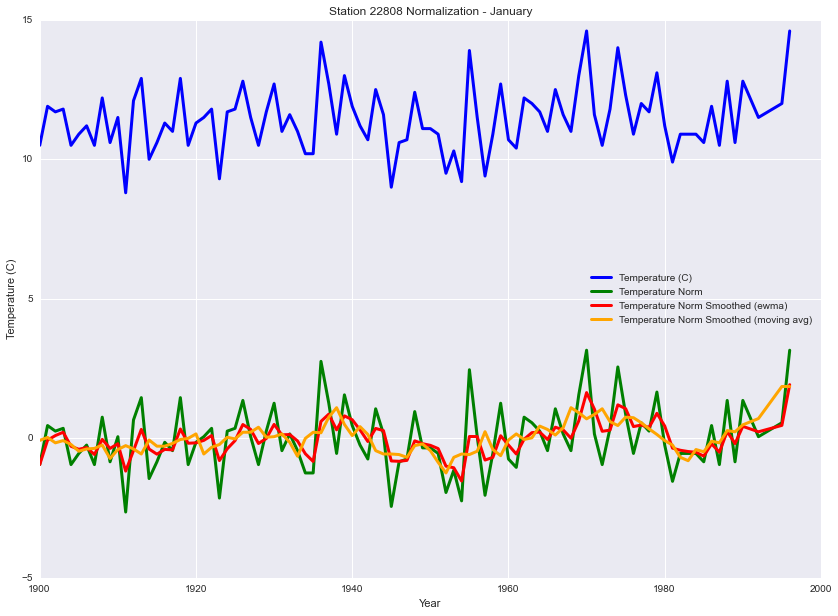

In [5]:
plt.figure(figsize=(14,10))
plt.plot(station_22808.Year,station_22808['Temperature (C)'] , color='blue',linewidth=3, label='Temperature (C)')
plt.plot(station_22808.Year,station_22808['Temperature Norm'] , color='green',linewidth=3, label='Temperature Norm')
plt.plot(station_22808.Year,station_22808['Temperature Norm Smoothed (ewma)'] , color='red',linewidth=3, label='Temperature Norm Smoothed (ewma)')
plt.plot(station_22808.Year,station_22808['Temperature Norm Smoothed (moving avg)'] , color='orange',linewidth=3, label='Temperature Norm Smoothed (moving avg)')
plt.legend(loc=5)
plt.title('Station 22808 Normalization - January')
plt.ylabel('Temperature (C)')
plt.xlabel('Year')
plt.show()

Focusing in the normalized values

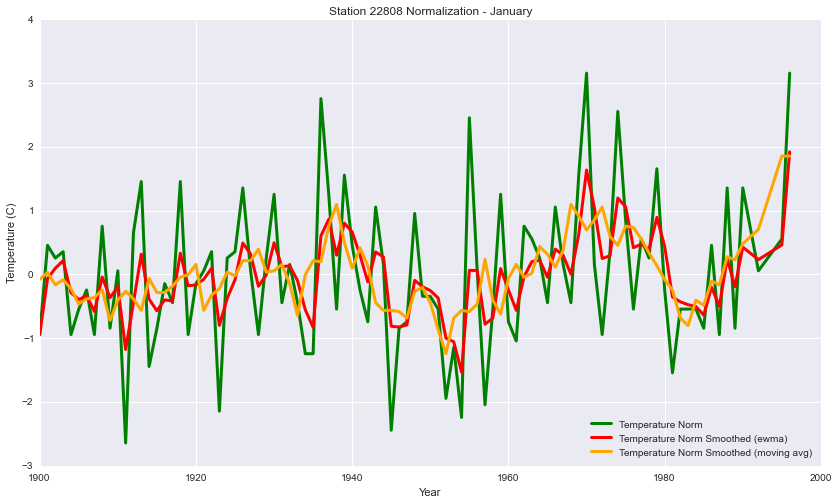

In [6]:
plt.figure(figsize=(14,8))
plt.plot(station_22808.Year,station_22808['Temperature Norm'] , color='green',linewidth=3, label='Temperature Norm')
plt.plot(station_22808.Year,station_22808['Temperature Norm Smoothed (ewma)'] , color='red',linewidth=3, label='Temperature Norm Smoothed (ewma)')
plt.plot(station_22808.Year,station_22808['Temperature Norm Smoothed (moving avg)'] , color='orange',linewidth=3, label='Temperature Norm Smoothed (moving avg)')
plt.legend(loc=4)
plt.title('Station 22808 Normalization - January')
plt.ylabel('Temperature (C)')
plt.xlabel('Year')
plt.show()

It is easy to see that in ewma normalization the same year value has more weight than in the moving avg. We will be able to check if moving avg can adjust a regression with less error than ewma

#Regression done by Date and station (splitting by isUrban) for Year>1970

In [7]:
df_urban70 = df_urban[df_urban.Year>1969]
df_isurban = df_urban70[df_urban70.isUrban==1]
df_nonurban = df_urban70[df_urban70.isUrban==0]

In [8]:
#Generate X and Y's for the different normalizations

Urban_X = pd.DataFrame(df_isurban.Date)
Non_Urban_X = pd.DataFrame(df_nonurban.Date)
Urban_Y = pd.DataFrame(df_isurban['Temperature Norm'])
Urban_Y_ma = pd.DataFrame(df_isurban['Temperature Norm Smoothed (moving avg)'])
Urban_Y_ewma = pd.DataFrame(df_isurban['Temperature Norm Smoothed (ewma)'])
Non_Urban_Y = pd.DataFrame(df_nonurban['Temperature Norm'])
Non_Urban_Y_ma = pd.DataFrame(df_nonurban['Temperature Norm Smoothed (moving avg)'])
Non_Urban_Y_ewma = pd.DataFrame(df_nonurban['Temperature Norm Smoothed (ewma)'])

#norm regression
regr = linear_model.LinearRegression()
regr.fit(Urban_X,Urban_Y)
regr2 = linear_model.LinearRegression()
regr2.fit(Non_Urban_X,Non_Urban_Y)

#moving average(ma) regression
regr_ma = linear_model.LinearRegression()
regr_ma.fit(Urban_X,Urban_Y_ma)
regr2_ma = linear_model.LinearRegression()
regr2_ma.fit(Non_Urban_X,Non_Urban_Y_ma)

#ewma regression
regr_ewma = linear_model.LinearRegression()
regr_ewma.fit(Urban_X,Urban_Y_ewma)
regr2_ewma = linear_model.LinearRegression()
regr2_ewma.fit(Non_Urban_X,Non_Urban_Y_ewma)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Organize results in a table

In [55]:
table = pd.DataFrame(columns=['isUrban','Normalization Type','Slope','Residual Sum of squares','Variance Score'],index=[1,2,3,4,5,6])

table['Normalization Type'].ix[1] = 'None'
table['Normalization Type'].ix[2] = 'ma'
table['Normalization Type'].ix[3] = 'ewma'
table['Normalization Type'].ix[4] = 'None'
table['Normalization Type'].ix[5] = 'ma'
table['Normalization Type'].ix[6] = 'ewma'

table['isUrban'].ix[1] = 1
table['isUrban'].ix[2] = 1
table['isUrban'].ix[3] = 1
table['isUrban'].ix[4] = 0
table['isUrban'].ix[5] = 0
table['isUrban'].ix[6] = 0

table['Slope'].ix[1] = round(regr.coef_[0][0],4)
table['Slope'].ix[4] = round(regr2.coef_[0][0],4)
table['Slope'].ix[2] = round(regr_ma.coef_[0][0],4)
table['Slope'].ix[5] = round(regr2_ma.coef_[0][0],4)
table['Slope'].ix[3] = round(regr_ewma.coef_[0][0],4)
table['Slope'].ix[6] = round(regr2_ewma.coef_[0][0],4)

table['Residual Sum of squares'].ix[1] = round(np.mean((regr.predict(Urban_X) - Urban_Y) ** 2),3)
table['Residual Sum of squares'].ix[4] = round(np.mean((regr2.predict(Non_Urban_X) - Non_Urban_Y) ** 2),3)
table['Residual Sum of squares'].ix[2] = round(np.mean((regr_ma.predict(Urban_X) - Urban_Y_ma) ** 2),3)
table['Residual Sum of squares'].ix[5] = round(np.mean((regr2_ma.predict(Non_Urban_X) - Non_Urban_Y_ma) ** 2),3)
table['Residual Sum of squares'].ix[3] = round(np.mean((regr_ewma.predict(Urban_X) - Urban_Y_ewma) ** 2),3)
table['Residual Sum of squares'].ix[6] = round(np.mean((regr2_ewma.predict(Non_Urban_X) - Non_Urban_Y_ewma) ** 2),3)


table['Variance Score'].ix[1] = round(regr.score(Urban_X, Urban_Y),4)
table['Variance Score'].ix[4] = round(regr2.score(Non_Urban_X, Non_Urban_Y),4)
table['Variance Score'].ix[2] = round(regr_ma.score(Urban_X, Urban_Y_ma),4)
table['Variance Score'].ix[5] = round(regr2_ma.score(Non_Urban_X, Non_Urban_Y_ma),4)
table['Variance Score'].ix[3] = round(regr_ewma.score(Urban_X, Urban_Y_ewma),4)
table['Variance Score'].ix[6] = round(regr2_ewma.score(Non_Urban_X, Non_Urban_Y_ewma),4)

table


,isUrban,Normalization Type,Slope,Residual Sum of squares,Variance Score
1,1,None,0.0268,1.833,0.0571
2,1,ma,0.0269,0.523,0.1754
3,1,ewma,0.0278,0.626,0.1597
4,0,None,0.0292,1.809,0.068
5,0,ma,0.0291,0.515,0.2022
6,0,ewma,0.0296,0.608,0.1822


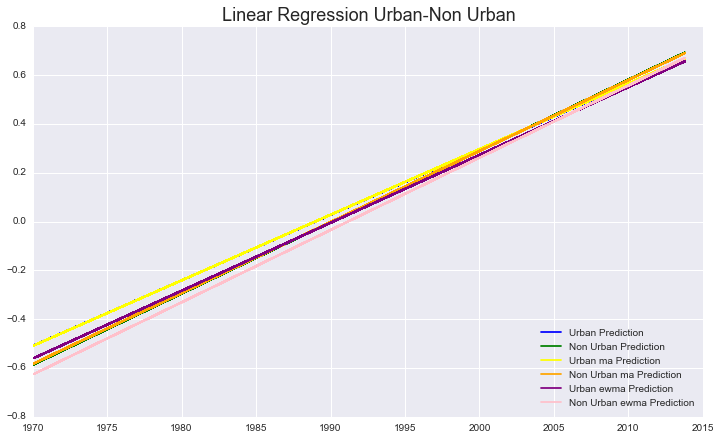

In [55]:
# Plot outputs
plt.figure(figsize=(12,7))

plt.plot(Urban_X, regr.predict(Urban_X), color='blue',label='Urban Prediction')
plt.plot(Non_Urban_X, regr2.predict(Non_Urban_X), color='green',label = 'Non Urban Prediction')

plt.plot(Urban_X, regr_ma.predict(Urban_X), color='yellow',label='Urban ma Prediction')
plt.plot(Non_Urban_X, regr2_ma.predict(Non_Urban_X), color='orange',label = 'Non Urban ma Prediction')

plt.plot(Urban_X, regr_ewma.predict(Urban_X), color='purple',label='Urban ewma Prediction')
plt.plot(Non_Urban_X, regr2_ewma.predict(Non_Urban_X), color='pink',label = 'Non Urban ewma Prediction')


plt.xlim((1970,2015))
plt.title('Linear Regression Urban-Non Urban', fontsize=18)
plt.legend(loc=4)

plt.show()